In [1]:
# Import required libraries

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Collect the news from finviv.com into tables

news_tables = {}
period = 20

finviz_url = 'https://finviz.com/quote.ashx?t='

tickers = ['AAL','AHT','AQMS','NIO']

for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent':'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response,'html.parser')

    news_table = html.find(id='news-table')
    news_tables[ticker]= news_table

In [3]:
# Extract the important variables from the data collected.

parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'):

        title = row.a.get_text()
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

In [4]:
# Store as dataframe

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df.head()

,ticker,date,time,title
0,AAL,Feb-09-21,10:46AM,Delta (DAL) to Keep Middle Seats Vacant Throug...
1,AAL,Feb-05-21,04:12PM,GameStop Stock Jumps As Robinhood Lifts Tradin...
2,AAL,Feb-05-21,02:43PM,"American, Alaska Airlines Expand Use Of VeriFL..."
3,AAL,Feb-05-21,10:01AM,"AAL Is Lagging the Benchmarks, But Thats a Rea..."
4,AAL,Feb-04-21,04:24PM,20 Fastest Growing Vacation Destinations in th...


In [5]:
# carry out the sentiment analysis on the  data

vader = SentimentIntensityAnalyzer()


condition = lambda title: vader.polarity_scores(title)['compound']  # Using a lambda function to treat each row of the compound function
df['compound'] = df['title'].apply(condition)       # Applying the condition on the compound feature
df['date'] = pd.to_datetime(df['date']).dt.date     # Convert the data column to pandas datetime
df.head()

,ticker,date,time,title,compound
0,AAL,2021-02-09,10:46AM,Delta (DAL) to Keep Middle Seats Vacant Throug...,0.0000
1,AAL,2021-02-05,04:12PM,GameStop Stock Jumps As Robinhood Lifts Tradin...,0.0000
2,AAL,2021-02-05,02:43PM,"American, Alaska Airlines Expand Use Of VeriFL...",0.3182
3,AAL,2021-02-05,10:01AM,"AAL Is Lagging the Benchmarks, But Thats a Rea...",-0.2732
4,AAL,2021-02-04,04:24PM,20 Fastest Growing Vacation Destinations in th...,0.1779


In [6]:
mean_df = df.groupby(['ticker','date']).mean().unstack().xs('compound', axis='columns').transpose()
mean_df = mean_df.iloc[-period:]
mean_df.tail()

ticker,AAL,AHT,AQMS,NIO
date,,,,
2021-02-05,0.015,NaN,NaN,-0.148000
2021-02-06,NaN,NaN,NaN,0.000000
2021-02-08,NaN,NaN,NaN,0.022483
2021-02-09,0.000,NaN,NaN,0.045533
2021-02-10,NaN,NaN,NaN,0.056489


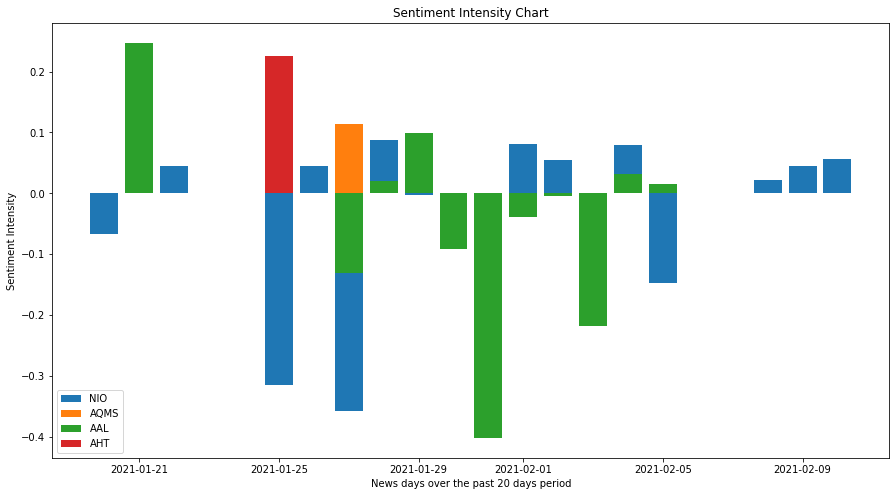

In [7]:
# Plot a bar chart to visualize our sentiments.

plt.figure(figsize=(15,8))

plt.bar(mean_df.index,mean_df.NIO , label='NIO') 
plt.bar(mean_df.index,mean_df.AQMS, label='AQMS')
plt.bar(mean_df.index,mean_df.AAL, label='AAL')
plt.bar(mean_df.index,mean_df.AHT, label='AHT')
plt.title('Sentiment Intensity Chart')
plt.xlabel('News days over the past 20 days period')
plt.ylabel('Sentiment Intensity')
plt.legend()

plt.show()